In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random as rn

In [2]:
class particle: 
    def __init__(self,m,x,y,vx=0,vy=0): 
        """
        Defines the particle. Each particle has a mass, a position and momentum
        Inputs: 
            - m (float): mass of the particle 
            - x,y (float): x and y components respectively of the particle's position 
            - vx,vy (float): x and y components respectively of the particle's velocity
        """
        self.mass = m 
        self.position = (x,y)
        self.velocity = (vx,vy)
    
def evolve(position,velocity,mass,f,dt):
    """
    Evolves the particle's position and momentum using the leap frog method seen in class
    Inputs: 
        - f_current (array): The forces on the particle 
        - f_new (array): changed forces on the particle 
        - dt (float): time step in seconds 
    """
    v = velocity + f*dt/mass
    x = position+(velocity)*dt
    return x,v 

def calculate_dist(grid,pos):
    """
    Calculates the position between a grid point and a particle's position
    """
    return np.sqrt((grid[0]-pos[0])**2+(grid[1]-pos[1])**2)

In [3]:
class system: 
    def __init__(self,npart,size,init_mass,npart_specific=None):
        """
        Defines the total system of particles and puts them in a list. 
        Inputs: 
            - npast (int): total number of particles 
            - size (int): (x,y) of the size of the grid 
        """
        def initial_condition(size,npart,npart_specific=None): 
            """
            Depending on the grid size, generates random position on the grid. 
            Makes sure that the particles do not get generated on top of each other.
            Inputs:
                - size (array): size of grid. In the format of (x,y)
                - npart (int): total number of particles of the system
                - npar_specific (array): specific boundary condition pre-defined by the user
            """
            init_cond = []
            if npart_specific is None: 
                l = 0
            else: 
                l = len(npart_specific)
                for k in range(l):
                    pos = (npart_specific[k][0], npart_specific[k][1])
                    init_cond.append(pos)

            for p in range(npart-l):
                pos = (rn.random())*(size[0]-1), (rn.random())*(size[1]-1)
                
                init_cond.append(pos)
                #Small code block to make sure no two particles are generated on-top 
                #of each other. Although it is highly unlikely but just to make sure 
                #j = 0 
                #if p!=0:
                #    while j<npart: 
                #        if init_cond[-2][0] == init_cond[-1][0] and init_cond[-2][1] == init_cond[-1][1]:
                #            x_in, y_in =  rn.random()*size[0], rn.random*size[1]
                #            init_cond.pop()
                #            init_cond.append([x_in,y_in])
                #            j = -1
                #        else: 
                #            j += 1
                            
            return init_cond
        
        self.nparticles = npart
        init_cond = initial_condition(size,npart,npart_specific=npart_specific)
        self.particles = np.asarray([particle(m,x[0],x[1]) for m,x in zip(init_mass,init_cond)])   
        self.velocities = np.asarray([self.particles[i].velocity for i in range(npart)])
        self.pos = np.asarray([self.particles[i].position for i in range(npart)])
        self.masses = init_mass
        
    def evolve_system(self,dt,size,f,type_p = False):
        self.pos, self.veclocities = evolve(self.pos,self.velocities,self.masses,f,dt)
        if type_p == True:
            self.pos = self.pos%(size[0]-1)  


In [12]:
class grid: 
    def __init__(self,size,particleList,dt,soft=0.1,G=1):
        self.size = size
        self.soft = soft
        self.G = G
        self.dt = dt
        self.posP = particleList.pos
        self.velocityP = particleList.velocities
        self.intPos = np.round(self.posP)
        self.gridPos = self.grid_Maker(self.posP)
        self.mass = particleList.masses
        x, y = np.arange(size[0],dtype=float), np.arange(size[0],dtype=float)
        self.mesh = np.array(np.meshgrid(x,y))
        
        # Density assignment using the Cloud-In-Cell method 
        self.density_assignment()

        self.green()
        
        self.pot()
    
    def grid_Maker(self,posP):
        """
        Function that generates the closest 4 gridpoints on the grid for each particle. 
        """
        gridPos = []
        #top right corner grid 
        gridPos = []
        gridPos.append(np.ceil(self.posP))  
        #top left corner grid
        gridPos.append(np.asarray([np.floor(self.posP[:,0]),np.ceil(self.posP[:,1])]).T) 
        #bottom right corner grid
        gridPos.append(np.asarray([np.ceil(self.posP[:,0]),np.floor(self.posP[:,1])]).T) 
        #bottom left corner grid 
        gridPos.append(np.floor(self.posP)) 
        
        return np.transpose(np.asarray(gridPos),axes=[1,0,-1])
    
    def updatePos(self,particleList):
        self.posP = particleList.pos
        self.velocityP = particleList.velocities
        self.intPos = np.round(self.posP)
        self.gridPos = self.grid_Maker(self.posP)
        self.mass = particleList.masses
        self.gridDensity = self.density_assignment() 
    
    #Step 1: Define the density assignment function
    def density_assignment(self):
        """
        Function that assigns the density based off the CIC method (cloud-in-cell) method
        """
        new_gridD = np.zeros((self.size[0],self.size[1]))
        
        for i in range(self.posP.shape[0]):
            for j in range(4):
                d = calculate_dist(self.gridPos[i,j],self.posP[i])
                new_gridD[int(self.gridPos[i,j,0]),int(self.gridPos[i,j,1])] += self.mass[i]*(1-d/np.sqrt(2))
        
        self.mesh_modified = tuple(self.intPos[:, i].astype('int') for i in range(2))

        self.densities = new_gridD
    
    #Step 2: Define the green function of the grid
    def green(self):
        r = np.sum(self.mesh**2,axis=0)
        r[r<self.soft**2] = self.soft**2
        r += self.soft**2
        r = np.sqrt(r)
        
        g = 1/(4*np.pi*r)
        
        #To get periodicity, we flip the corners to get the same behavior around
        h_x,h_y = self.size[0]//2, self.size[1]//2
        
        #For now works for square grids only

        try:
            g[h_x:, :h_y] = np.flip(g[:h_x,:h_y],axis=0)
            g[:,h_y:] = np.flip(g[:,:h_y],axis=1)
        except: 
            g[h_x:, :h_y+1] = np.flip(g[:h_x+1,:h_y+1],axis=0)
            g[:,h_y:] = np.flip(g[:,:h_y+1],axis=1)
        self.g = g
        print(self.g.shape)
            
            
    def pot(self):
        #To get the potential, we just multiply the fourier transformed density with
        #the fourier transformed green function
        
        ffD = np.fft.rfft2(self.densities)
        ffG = np.fft.rfft2(self.g)
        ffV = ffD*ffG
        
        V = np.fft.irfft2(ffV)
        
        #Need to shift and average the potential to center it back to particle
        for i in range(2):
            V = 0.5*(np.roll(V,1,axis=i)+V)
            
        return V 
    
    def forces_mesh(self): 
        fmesh = np.zeros([2,self.size[0],self.size[1]])
        V = self.pot()
        
        #Gradient in each direction
        for i in range(2):
            fmesh[i] = 0.5*(np.roll(V,1,axis=i) - np.roll(V,-1,axis=i))
    
        fmesh *= -self.densities*self.G
        return fmesh 
    
    #Interpolate forces to particles
    def forces_pctls(self):
        #use the inverse of the mass scheme to interpolate forces back to particle
        #work on the inverse scheme
        
        fxy = np.moveaxis(self.forces_mesh(),0,-1)
        mesh_m = self.mesh_modified
        f_final = fxy[self.mesh_modified]
        #fpart =  
        return f_final
    
    def totalEnergy(self):
        K = np.sum(self.mass*self.velocityP**2)
        P = -0.5*np.sum(np.sum(self.pot())*self.densities)
        T = K + P
        return T 
    
    def evolve(self,nsteps):
        for i in range(nsteps):
            #print (g.gridPos)
            #x,y = g.gridPos[0][i]
            #x = int(x)
            #y = int(y)

            #acc_new[i][0] += (1/g.mass[i]*F[0][x,y])
            #acc_new[i][1] += (1/g.mass[i]*F[1][x,y])

            F = self.forces_pctls()

            s.evolve_system(self.dt,self.size,F,type_p= True)

            self.updatePos(s)
        energy = self.totalEnergy()
        return energy


    #    return 0

MovieWriter imagemagick unavailable. Trying to use pillow instead.


(64, 64)
Step 0: Total Energy is -576.3901412138325
Step 0: Total Energy is -576.3901412138325
Step 1: Total Energy is -576.3901412138325
Step 2: Total Energy is -576.3901412138325
Step 3: Total Energy is -576.3901412138325
Step 4: Total Energy is -576.3901412138325
Step 5: Total Energy is -576.3901412138325
Step 6: Total Energy is -576.3901412138325
Step 7: Total Energy is -576.3901412138325
Step 8: Total Energy is -576.3901412138325
Step 9: Total Energy is -576.3901412138325
Step 10: Total Energy is -576.3901412138325
Step 11: Total Energy is -576.3901412138325
Step 12: Total Energy is -576.3901412138325
Step 13: Total Energy is -576.3901412138325
Step 14: Total Energy is -576.3901412138325
Step 15: Total Energy is -576.3901412138325
Step 16: Total Energy is -576.3901412138325
Step 17: Total Energy is -576.3901412138325
Step 18: Total Energy is -576.3901412138325
Step 19: Total Energy is -576.3901412138325
Step 20: Total Energy is -576.3901412138325
Step 21: Total Energy is -576.3901

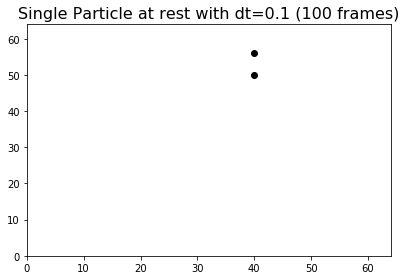

In [13]:
npart = 2
size = (2**6,2**6)
init_mas = [rn.random() for t in range(npart)]
npart_specific = [[40,50],[40,56]]
s = system(npart,size,init_mas,npart_specific=npart_specific)
#acc = np.zeros([len(s.pos[:,0]),2])
dt = 0.1
g = grid(size,s,dt,soft=0.01)
#acc_new = np.zeros([len(s.pos[:,0]),2])
niter = 100

title = 'Single Particle at rest with dt={} ({} frames)'.format(dt, niter)
figpath = './part1_move.gif'

# Animation (.gif file)
grid_animation2d(g, niter=niter, show=False, savepath=figpath,
                    figsize=None, intv=200,title=title, repeat=False, marker='ko', style='pts')

In [140]:
np.meshgrid([10,60],[600,900])


[array([[10, 60],
        [10, 60]]), array([[600, 600],
        [900, 900]])]

In [141]:
ndim = 2
ngrid = 10
print (s.pos)
_meshpts = np.rint(s.pos).astype('int') % ngrid
# for quick access in grid-like arrays
_meshinds = tuple(_meshpts[:, i] for i in range(ndim))
print (_meshpts)
print (_meshinds)

[[4.19167315 8.86942221]
 [0.8260565  5.17440319]]
[[4 9]
 [1 5]]
(array([4, 1], dtype=int32), array([9, 5], dtype=int32))


In [136]:
shape = [ndim]
shape.extend([ngrid]*ndim)
fmesh = np.zeros(shape, dtype=float)

In [137]:
print (fmesh)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


In [5]:
from matplotlib import animation
import matplotlib.pyplot as plt
import warnings

def evoframe(frames, model, plot, type, nsteps, marker, logfile=None):
    """Evolve figure with model in 2D
    Evolves a figure according to model evolution. Mainly useful for matplotlib
    animations with animation.FuncAnimation.
    Args:
        frames        (int): frame number, for compat with mpl animation
        model (nbody.NBody): Nbody model to be displayed
        plot     (mpl plot): matplotlib plot showing model data (densities)
        type          (str): type of animation plot (density grid or scatter
                             plot)
        marker        (str): marker for matplotlib scatter plot, used if
                             type == 'pts' only
        logfile       (str): file where we output the energy at each step.
                             Default is None.
    """
    eg = model.evolve(nsteps=nsteps)
    egstr = 'Step {}: Total Energy is {}'.format(frames, eg)
    print(egstr)
    if logfile is not None:
        lf = open(logfile, 'a')
        lf.write(''.join([egstr, '\n']))
        lf.close()

    if type == 'grid':
        plot.set_array(model.density.T)
    elif type == 'pts':
        plot.set_data(model.posP[:, 0], model.posP[:, 1])


def evoframe3d(frames, model, plot, type, nsteps, marker, logfile=None):
    """Evolve figure with model (in 3d, collapsing model on 3rd dim)
    Evolves a figure according to model evolution. Mainly useful for matplotlib
    animations with animation.FuncAnimation.
    Args:
        frames        (int): frame number, for compat with mpl animation
        model (nbody.NBody): Nbody model to be displayed
        plot     (mpl plot): matplotlib plot showing model data (densities)
        type          (str): type of animation plot (density grid or scatter
                             plot)
        marker        (str): marker for matplotlib scatter plot, used if
                             type == 'pts' only
        logfile       (str): file where we output the energy at each step.
                             Default is None.
    """
    eg = model.evolve(nsteps=nsteps)
    egstr = 'Step {}: Total Energy is {}'.format(frames, eg)
    print(egstr)
    if logfile is not None:
        lf = open(logfile, 'a')
        lf.write(''.join([egstr, '\n']))
        lf.close()

    if type == 'grid':
        density = np.sum(model.density, axis=-1)
        plot.set_array(density.T)
    elif type == 'pts':
        plot.set_data(model.posP[:, 0], model.posP[:, 1])


def grid_animation2d(model, niter=50, show=True, savepath=None,
                     figsize=(8, 10), intv=200, title=None, repeat=False,
                     nsteps=1, style='grid', marker='o', norm=None, cmap=None,
                     logfile=None):
    """Animation of 2d nbody model
    Creates an animation of a 2d nbody model with one evolution timestep per
    frame.
    Args:
        model (nbody.NBody): Nbody model to be displayed
        niter         (int): number of evolution timesteps in the animation
        show         (bool): show the animation if true (default is true)
        savepath      (str): path where the animation should be saved. Not
                             saved when None, default is None. Must end by
                             '.gif' (file format)
        figsize     (tuple): width and heigth of mpl figure.
        intv        (float): delay (in milliseconds) between frames in
                             animation.
        title         (str): Title of the figure. No title if None (default).
        repeat       (bool): If true, repeat animation indefintely. Default is
                             False.
        nsteps        (int): Number of evolution steps for model between
                             frames.
        style         (str): 'grid' (default) or 'pts', to choose between
                             density grid or scatterplot.
        marker        (str): specifying the marker style for matplotlib scatter
                             plot (used if style=='pts' only)
        norm          (str): matplotlib grid normalization. Default is None
                             (system matplotlib settings)
        cmap          (str): specifying color map to use for density grid.
        logfile       (str): File where we output the energy at each frame.
    """
    if logfile is not None:
        lf = open(logfile, 'w')
        lf.close()

    # font parameters
    titlesize = 16

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if title is not None:
        ax.set_title(title, fontsize=titlesize)
    if style == 'grid':
        plot = ax.imshow(model.density.T, norm=norm)
    elif style == 'pts':
        plot, = ax.plot(model.posP[:, 0], model.posP[:, 1], marker)
    ax.set_xlim([0, g.size[0]])
    ax.set_ylim([0, g.size[1]])
    plt.tight_layout()

    fargs = (model, plot, style, nsteps, marker, logfile)
    anim = animation.FuncAnimation(fig, evoframe, frames=niter, interval=intv,
                                   fargs=fargs, repeat=repeat)
    if savepath is not None:
        fformat = savepath.split('.')[-1]
        if fformat != 'gif':
            msg = ('Incorrect file format (.{} instead of .gif). Animation'
                   ' will not be saved.')
            warnings.warn(msg, RuntimeWarning)
        else:
            anim.save(savepath, writer='imagemagick')
    if show:
        plt.show()